## Instalações e imports:

In [2]:
!pip install selenium
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 3.5 MB/s eta 0:00:00


In [19]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import requests
from bs4 import BeautifulSoup
from unidecode import unidecode
from google.colab import files
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import time

## Web Scraper Gupy:

In [4]:
# Palavras-chave para a pesquisa
pesquisa = "dados"

# Caso driver pare antes - aumentar o tempo de pausa (tempo de execução é impactado mas garante resultado uniforme)
SCROLL_PAUSE_TIME = 2

In [5]:
# Configurações do webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options=options)
url = f'https://portal.gupy.io/job-search/term={pesquisa}'

driver.get(url)

# Driver realiza leitura da página - Vagas aparecem de acordo com o scroll do usuário
last_height = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = driver.execute_script("return document.body.scrollHeight")
    # se parar de scrollar para baixo, sair do loop
    if new_height == last_height:
        break
    last_height = new_height

html_content = driver.page_source

# Beautifulsoup para separar os valores a obter somente o que é relevante da página
soup = BeautifulSoup(html_content, 'html.parser')
blocks = soup.find_all('div', class_='sc-a3bd7ea-0 HCzvP')
# UTC+0
current_time = time.strftime("%d-%m-%Y")
csv_filename = f'vagas_gupy_{pesquisa}_{current_time}.csv'

with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Empresa', 'Cargo', 'Local', 'Data publicacao', 'Tipo de cargo', 'Remoto/Presencial'])

    for block in blocks:
        # Valores padrão encontrados nos blocos de vaga - source code da página
        company_name_elem = block.select_one('p.sc-efBctP.dpAAMR.sc-a3bd7ea-6.cQyvth')
        job_title_elem = block.select_one('h2')
        location_elem = block.find('span', class_='sc-23336bc7-1 cezNaf')
        published_date_elem = block.find('div', class_="sc-1db88588-1 joOyhp")
        span_elems = block.find_all('span', class_='sc-23336bc7-1 cezNaf')

        # Verifica se há texto para todos os elementos, se não tiver, escreve N/A
        company_name = unidecode(company_name_elem.text.strip()) if company_name_elem else "N/A"
        job_title = unidecode(job_title_elem.text.strip()) if job_title_elem else "N/A"
        location = unidecode(location_elem.text.strip()) if location_elem else "N/A"
        published_date_text = published_date_elem.find('p').text.strip() if published_date_elem else "N/A"
        published_date = published_date_text.replace("Publicada em: ", "")
        span_values = [unidecode(span.text.strip()) for span in span_elems]

        # Escreve linhas no CSV
        row_data = [company_name, job_title, location, published_date, span_values[2], span_values[1]]
        csv_writer.writerow(row_data)

driver.quit()

files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Análise dos dados:

In [6]:
#Visualiza os 5 primeiros valores do CSV
df = pd.read_csv(csv_filename)
df.head()

,Empresa,Cargo,Local,Data publicacao,Tipo de cargo,Remoto/Presencial
0,White Martins,Estagiario(a) de Analise de Dados - Diadema/SP,Diadema - SP,17/08/2023,Estagio,Presencial
1,Grupo Salta Educacao,Analista de Dados - Contas a Receber,Rio de Jan... - RJ,17/08/2023,Efetivo,Presencial
2,NAVA | Technology for Business,Pessoa Engenheira de Dados,Sao Paulo - SP,17/08/2023,Efetivo,Presencial
3,"LBCA - Lee, Brock, Camargo Advogados",Analista de Dados Juridicos,Sao Paulo - SP,17/08/2023,Efetivo,Remoto
4,BP - A Beneficencia Portuguesa de Sao Paulo,Pessoa Analista de Dados Pleno,Sao Paulo - SP,17/08/2023,Efetivo,Presencial


In [18]:
# DISCLAIMER: A análise foi feita sobre o CSV de pesquisa de "dados" na GUPY
blacklisted_words = ["de", "-", "Brasil", "Não", "Nao", "Informado", "informado", "|", "DE", "Sao", "Paulo", "Rio", "Jan...", "Belo", "Horiz...", "Pessoa", "e", "Banco"]

def most_common_words(column, num_words=6):
    words = ' '.join(column).split()

    words = [word for word in words if word not in blacklisted_words]

    word_counts = Counter(words)
    most_common = word_counts.most_common(num_words)

    return most_common

for column in df.columns:
    most_common = most_common_words(df[column])
    if most_common:
        print(f"Palavras mais comuns em '{column}': {most_common}")
    else:
        print(f"Coluna vazia -> '{column}'.")

Palavras mais comuns em 'Empresa': [('Group', 25), ('Tech', 23), ('Itau', 22), ('Business', 21), ('Stefanini', 21), ('Unibanco', 21)]
Palavras mais comuns em 'Cargo': [('Dados', 436), ('Analista', 205), ('DADOS', 81), ('Senior', 64), ('Engenheiro', 49), ('Pleno', 48)]
Palavras mais comuns em 'Local': [('SP', 279), ('RJ', 57), ('MG', 29), ('DF', 26), ('RS', 25), ('Brasilia', 24)]
Palavras mais comuns em 'Data publicacao': [('14/08/2023', 24), ('11/08/2023', 18), ('09/08/2023', 18), ('08/08/2023', 18), ('03/08/2023', 17), ('31/07/2023', 17)]
Palavras mais comuns em 'Tipo de cargo': [('Efetivo', 453), ('Talentos', 50), ('Estagio', 32), ('Juridica', 25), ('Associado', 5), ('Freelancer', 3)]
Palavras mais comuns em 'Remoto/Presencial': [('Presencial', 373), ('Remoto', 199)]


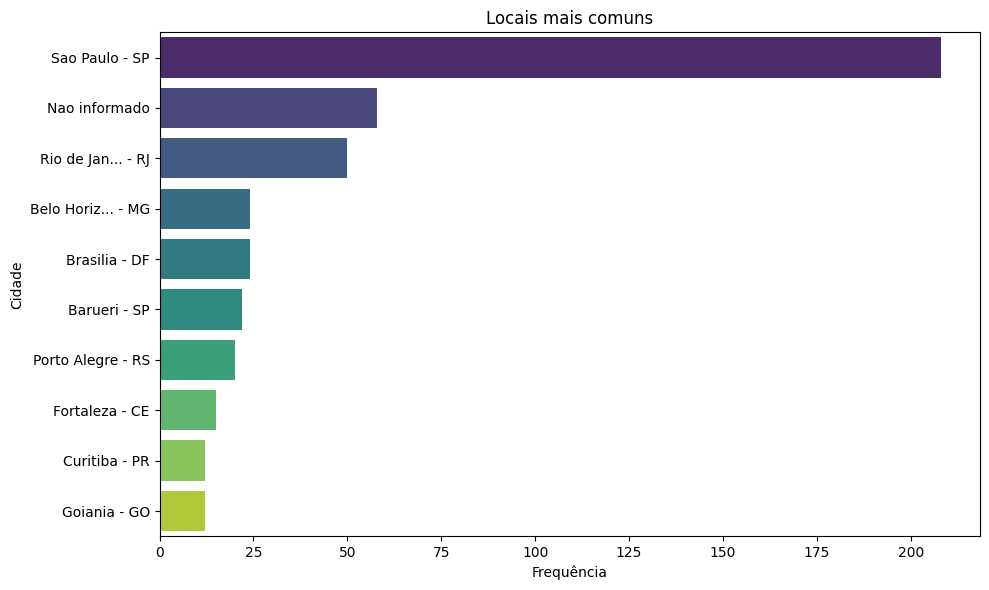

In [16]:
most_common_locations = df['Local'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=most_common_locations.values, y=most_common_locations.index, palette='viridis')
plt.title('Locais mais comuns')
plt.xlabel('Frequência')
plt.ylabel('Cidade')
plt.tight_layout()
plt.show()



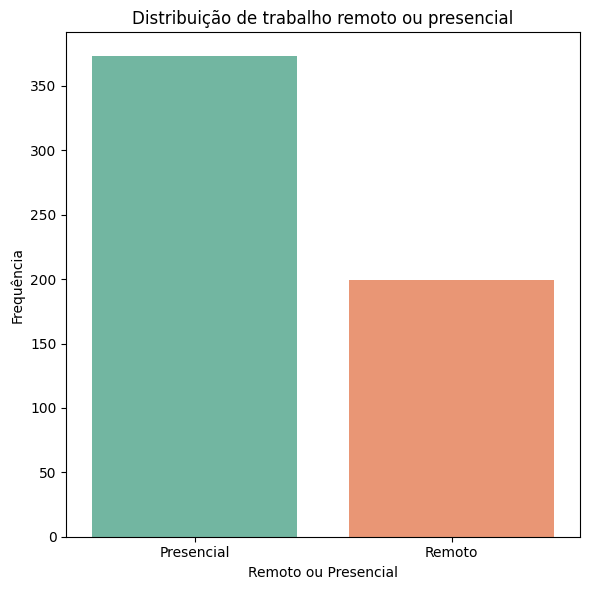

In [14]:
job_type_distribution = df['Remoto/Presencial'].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(x=job_type_distribution.index, y=job_type_distribution.values, palette='Set2')
plt.title('Distribuição de trabalho remoto ou presencial')
plt.xlabel('Remoto ou Presencial')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

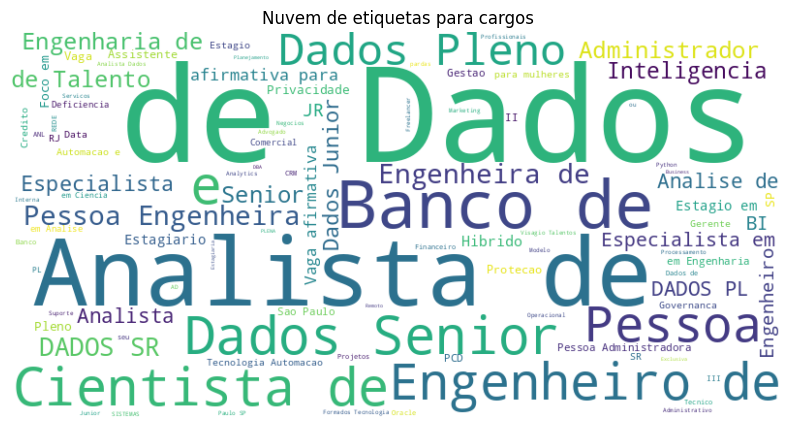

In [27]:
def generate_word_cloud(text_column, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(text_column))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

generate_word_cloud(df['Cargo'], 'Nuvem de etiquetas para cargos')

### Análise dos dados:

A partir da análise de palavras mais comuns e visualizações de frequência para localização ou de trabalho remoto ou presencial é possível visualizar padrões com grande foco em São Paulo e Rio de Janeiro para vagas de dados. Foi considerado uma análise mais estatística usando Chi-square mas foi descartada por não ser necessário já que a amostra é pequena e compreensível visualmente. Há uma maior preferência pelos contratantes pelo regime presencial, o que um tempo atrás - por causa da pandemia - era invertido.

Quanto a frequência das palavras há uma maior busca por Analistas de dados, com 205 ocorrências seguido por Engenheiros de dados com 45.

## Benchmark de performance sem Selenium:

In [ ]:
# Webscraping sem Selenium (acessa somente as vagas carregadas com a página) - teste de performance

pesquisa = "dados"


url = f'https://portal.gupy.io/job-search/term={pesquisa}'
response = requests.get(url)
html_content = response.text
soup = BeautifulSoup(html_content, 'html.parser')

blocks = soup.find_all('div', class_='sc-a3bd7ea-0 HCzvP')

for block in blocks:
  company_name_elem = block.select_one('p.sc-efBctP.dpAAMR.sc-a3bd7ea-6.cQyvth')
  job_title_elem = block.select_one('h2')
  location_elem = block.find('span', class_='sc-23336bc7-1 cezNaf')
  published_date_elem = block.find('div', class_="sc-1db88588-1 joOyhp")
  span_elems = block.find_all('span', class_='sc-23336bc7-1 cezNaf')

  company_name = unidecode(company_name_elem.text.strip()) if company_name_elem else "N/A"
  job_title = unidecode(job_title_elem.text.strip()) if job_title_elem else "N/A"
  location = unidecode(location_elem.text.strip()) if location_elem else "N/A"
  published_date_text = published_date_elem.find('p').text.strip() if published_date_elem else "N/A"
  published_date = published_date_text.replace("Publicada em: ", "")
  span_values = [unidecode(span.text.strip()) for span in span_elems]

  print("Empresa:", company_name)
  print("Cargo:", job_title)
  print("Localização:", location)
  print(published_date)
  print("Tipo de cargo:", span_values[2])
  print("Remoto ou presencial:", span_values[1])
  print()



Empresa: LEAN SALES
Cargo: Assistente De Dados
Localização: Itajai - SC
16/08/2023
Tipo de cargo: Efetivo
Remoto ou presencial: Presencial

Empresa: NAVA | Technology for Business
Cargo: PESSOA ESPECIALISTA DE GOVERNANCA DE DADOS
Localização: Sao Paulo - SP
16/08/2023
Tipo de cargo: Efetivo
Remoto ou presencial: Presencial

Empresa: Daniel Advogados
Cargo: Cientista de Dados
Localização: Rio de Jan... - RJ
16/08/2023
Tipo de cargo: Efetivo
Remoto ou presencial: Presencial

Empresa: NAVA | Technology for Business
Cargo: ANALISTA  DLP e PROTECAO DE DADOS SR
Localização: Osasco - SP
16/08/2023
Tipo de cargo: Efetivo
Remoto ou presencial: Presencial

Empresa: NAVA | Technology for Business
Cargo: ANALISTA  DLP e PROTECAO DE DADOS SR
Localização: Osasco - SP
16/08/2023
Tipo de cargo: Efetivo
Remoto ou presencial: Presencial

Empresa: NAVA | Technology for Business
Cargo: ANALISTA DE PROTECAO DE DADOS SR - DISCOVERY, PROTECAO E CRIPTOGRAFIA
Localização: Osasco - SP
16/08/2023
Tipo de cargo: 